# Italian Electricity Price forecasting

**Electricity** has always been something that we've taken for granted, but it is precisely when something seems particularly obvious to us that it becomes important when an exogenous shock occurs.

For the last 20 years being dependent on the Russian Gas has not been a problem for Italy it has been rather advantageous because gas was pretty cheap.

All this has changed in the last year (2021-2022): supply chains disruptions, government push toward green energy sources, and geopolitical tensions made the previous scenario a dream.

A more diverse energy mix has now become the top priority of Italy, both from a source of electricity point of view and from how we diversify within the source itself.

Knowing how the demand and price of electricity have moved over time is a key asset. That's because the electricity production could be programmed and optimized over the day so everyone benefits from it: people and also the environment.

As a data scientist, one way for helping to tackle the problem is by building a **forecasting model** that isn't only going to forecast a single number but a **"confidence interval"** that could be more meaningful than just a raw number.

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader

from tft.model import TFT, QuantileLoss
from tft.utils import TSDataset

In [2]:
# Set seeds
torch.manual_seed(0)
np.random.seed(0)

In [3]:
price_path = '../data/it_electricity_prices_adj.csv'
save_model_path = '../results/tft_price_it.chkpt'

In [4]:
price_df = pd.read_csv(price_path, index_col=0, parse_dates=True)
price_df = price_df.sort_index()
price_df

,PUN,NAT,CNOR,CSUD,NORD,SARD,SICI,SUD,AUST,COAC,CORS,FRAN,GREC,SLOV,SVIZ,BSP
2012-01-01 01:00:00,82.813341,76.29,83.9500,83.9500,83.9500,83.9500,70.03,83.95,83.9500,83.9500,83.9500,83.9500,83.95,83.9500,83.9500,23.6700
2012-01-01 02:00:00,75.767425,65.80,77.2700,77.2700,77.2700,77.2700,59.03,77.27,77.2700,77.2700,77.2700,77.2700,77.27,77.2700,77.2700,12.2700
2012-01-01 03:00:00,59.919853,60.00,60.0000,60.0000,60.0000,60.0000,59.03,60.00,60.0000,60.0000,60.0000,60.0000,60.00,60.0000,60.0000,5.0000
2012-01-01 04:00:00,59.920928,59.03,60.0000,60.0000,60.0000,60.0000,59.03,60.00,60.0000,60.0000,60.0000,60.0000,60.00,60.0000,60.0000,0.5000
2012-01-01 05:00:00,59.010000,59.00,59.0100,59.0100,59.0100,59.0100,59.01,59.01,59.0100,59.0100,59.0100,59.0100,59.01,59.0100,59.0100,0.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31 19:00:00,297.516870,299.55,300.0000,300.0000,300.0000,300.0000,282.68,282.68,300.0000,300.0000,300.0000,300.0000,282.68,300.0000,300.0000,300.0000
2022-03-31 20:00:00,347.646830,316.60,356.0934,356.0934,356.0934,356.0934,298.00,298.00,356.0934,356.0934,356.0934,356.0934,298.00,356.0934,356.0934,356.0934
2022-03-31 21:00:00,301.338720,289.12,309.1000,299.6000,309.1000,299.6000,269.51,269.51,309.1000,299.6000,309.1000,309.1000,269.51,309.1000,309.1000,309.1000
2022-03-31 22:00:00,282.150800,286.99,289.1200,269.5100,289.1200,269.5100,269.51,269.51,289.1200,269.5100,289.1200,289.1200,269.51,289.1200,289.1200,289.1200


Text(0.5, 0, 'date')

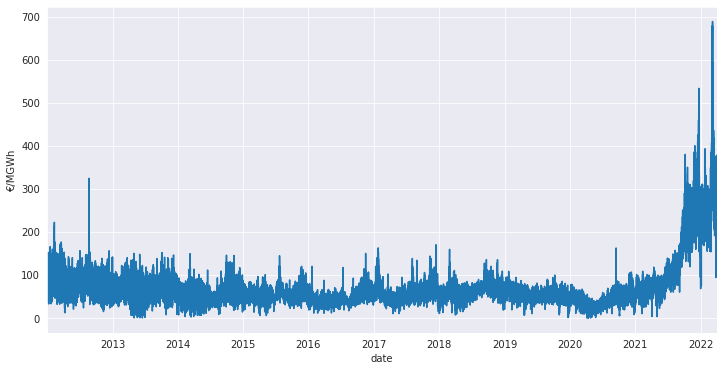

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
price_df.PUN.plot(ax=ax)
plt.ylabel('€/MGWh')
plt.xlabel('date')

# Preprocessing

The preprocessing phase consist in standard feature engineering practices:

- Standardize the data: we know that neural net like standardized data
    - the target of the model is `PUN` (which stand for 'Prezzo Unico Nazionale', Single National Price in english), I'm going to keep a StandardScaler for the input data and one different StandardScaler for the output data
- Add categorical time varying features such as day, month, hour
- Add static features (if it's working day or not, ...)

In [6]:
cols_to_keep = ['PUN', 'NAT', 'CNOR', 'CSUD', 'NORD', 'SARD', 'SICI', 'SUD']

In [7]:
price_df = price_df[cols_to_keep]
target_df = pd.DataFrame(price_df.PUN)

In [8]:
input_sc = StandardScaler()
output_sc = StandardScaler()
price_df.loc[:, cols_to_keep] = input_sc.fit_transform(price_df[cols_to_keep])
target_df.PUN = output_sc.fit_transform(target_df)

/home/paolo/PycharmProjects/th-bot/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/paolo/PycharmProjects/th-bot/venv/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [9]:
price_df = price_df.assign(hour=0)
price_df = price_df.assign(month=0)
price_df = price_df.assign(weekday=0)

price_df.loc[:, 'month'] = price_df.index.month
price_df.loc[:, 'hour'] = price_df.index.hour
price_df.loc[:, 'weekday'] = price_df.index.weekday

price_df = price_df.assign(working_day=1)
price_df.loc[price_df[price_df.weekday == 6].index, 'working_day'] = 0
price_df.loc[price_df[price_df.weekday == 5].index, 'working_day'] = 0

In [10]:
price_df.month = price_df.month - 1

In [11]:
price_df

,PUN,NAT,CNOR,CSUD,NORD,SARD,SICI,SUD,hour,month,weekday,working_day
2012-01-01 01:00:00,0.340578,0.224498,0.371694,0.395128,0.370774,0.355621,-0.155130,0.438354,1,0,6,0
2012-01-01 02:00:00,0.195625,0.011880,0.236593,0.257202,0.235452,0.224062,-0.365463,0.297670,2,0,6,0
2012-01-01 03:00:00,-0.130400,-0.105679,-0.112690,-0.099382,-0.114398,-0.116060,-0.365463,-0.066044,3,0,6,0
2012-01-01 04:00:00,-0.130378,-0.125339,-0.112690,-0.099382,-0.114398,-0.116060,-0.365463,-0.066044,4,0,6,0
2012-01-01 05:00:00,-0.149118,-0.125948,-0.132713,-0.119823,-0.134453,-0.135558,-0.365845,-0.086894,5,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31 19:00:00,4.757578,4.749688,4.741268,4.856041,4.747449,4.610602,3.910979,4.623702,19,2,3,1
2022-03-31 20:00:00,5.788880,5.095270,5.875747,6.014235,5.883772,5.715329,4.203915,4.946348,20,2,3,1
2022-03-31 21:00:00,4.836203,4.538286,4.925314,4.847782,4.931794,4.602724,3.659154,4.346335,21,2,3,1
2022-03-31 22:00:00,4.441459,4.495113,4.521222,4.226496,4.527045,4.010119,3.659154,4.346335,22,2,3,1


In [12]:
target_df

,PUN
2012-01-01 01:00:00,0.340578
2012-01-01 02:00:00,0.195625
2012-01-01 03:00:00,-0.130400
2012-01-01 04:00:00,-0.130378
2012-01-01 05:00:00,-0.149118
...,...
2022-03-31 19:00:00,4.757578
2022-03-31 20:00:00,5.788880
2022-03-31 21:00:00,4.836203
2022-03-31 22:00:00,4.441459


In [13]:
static_cols = ['working_day']
cat_cols = ['month', 'hour', 'weekday']
input_cols = cols_to_keep + cat_cols
output_col = 'PUN'
input_timesteps = 192
encoder_len = 168
output_timesteps = 24

Now that we've done all the preprocessing steps let's split our dataset into a train set, validation set and test set.

For the train set we are going to use the first 80% of the data, the val is going to be the 10% of the data after the train set and the test set is going to be composed by the rest of the data.

In [14]:
train_size = 0.8
val_size = 0.1

last_train_idx = int(np.round(len(price_df) * train_size))
last_val_idx = last_train_idx + int(np.round(len(price_df) * val_size))

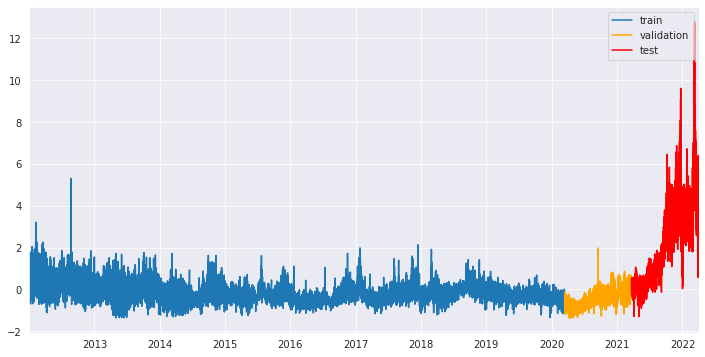

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

price_df.PUN[0:last_train_idx].plot(ax=ax, label='train')
price_df.PUN[last_train_idx:last_val_idx].plot(ax=ax, color='orange', label='validation')
price_df.PUN[last_val_idx:].plot(ax=ax, color='red', label='test')

plt.legend()
plt.show()

In [16]:
trainset = TSDataset(data=price_df[0:last_train_idx], target=target_df[0:last_train_idx],
                     static_cols=static_cols, input_cols=input_cols,
                    input_timesteps=input_timesteps, output_timesteps=output_timesteps, 
                     encoder_len=encoder_len)
valset = TSDataset(data=price_df[last_train_idx:last_val_idx], target=target_df[last_train_idx:last_val_idx],
                   static_cols=static_cols, input_cols=input_cols,
                   input_timesteps=input_timesteps, output_timesteps=output_timesteps,
                   encoder_len=encoder_len)
testset = TSDataset(data=price_df[last_val_idx:], target=target_df[last_val_idx:], static_cols=static_cols,
                    input_cols=input_cols, input_timesteps=input_timesteps,
                    output_timesteps=output_timesteps, encoder_len=encoder_len)

# Model - Temporal Fusion Transformer

The model that I've decided to use is the **Temporal Fusion Transformer**. Apart from leverage the transformer architecture and the attention mechanism, this model is not going to output a single number but an **interval** via quantile forecast to determine the range of likely target values at each prediction horizion.


For those of you that would like to deepen the model here's the link to the [paper](https://arxiv.org/pdf/1912.09363.pdf).

![assets/img.png](/home/paolo/PycharmProjects/pytorch-playground/assets/img.png)

In [17]:
CUDA = torch.cuda.is_available()
device = 'cuda' if CUDA else 'cpu'

Before train the network, It's always a good practice to initialize in a proper manner the neural net weights. Here I've decided to use the Glorot Uniform initialization function.

$$
\mathcal{U}(-a, a)
$$

where

$$
a = \sqrt{\frac{6}{n_{in} + n_{out}}}
$$

In [18]:
@torch.no_grad()
def init_xuniform(m):
  if isinstance(m, nn.Linear):
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)

In [19]:
static_cols = ['working_day']
categorical_cols = ['hour', 'month', 'weekday']
real_cols = cols_to_keep
config = {
    'static_variables': len(static_cols),
    'time_varying_categorical_variables': len(categorical_cols),
    'time_varying_real_variables_encoder': len(real_cols),
    'time_varying_real_variables_decoder': len(real_cols) - 1,
    'num_masked_series': 1,
    'static_embedding_vocab_sizes': [2],
    'time_varying_embedding_vocab_sizes': [12, 24, 7],
    'embedding_dim': 8,
    'lstm_hidden_dimension': 160,
    'lstm_layers': 1,
    'dropout': 0.05,
    'device': device,
    'batch_size': 64,
    'encode_length': 168,
    'attn_heads': 4,
    'num_quantiles': 3,
    'valid_quantiles': [0.1, 0.5, 0.9],
    'seq_length': 192
}

In [20]:
num_outputs = 24
epochs = 25
lr = 0.000115696
loss_fn = QuantileLoss(config['valid_quantiles'])
model = TFT(config)
model = model.to(device)
model.apply(init_xuniform)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### Train Loop

In [21]:
def train(
    epochs, 
    batch_size, 
    model,
    optimizer,
    loss_fn, 
    trainset
):

  training_losses = []
  validation_losses = []

  for epoch in range(epochs):
    model.train()
    epoch_losses = []
    total_loss = 0
    start_time = time.time()

    i = 0

    for batch_S, batch, batch_labels in DataLoader(trainset, batch_size,
                                                   shuffle=True,
                                                   num_workers=0,
                                                   drop_last=True):
      optimizer.zero_grad()

      out, _, _, _, _, _, _ = model(batch.to(device), batch_S.to(device))
      loss = loss_fn(out, batch_labels.to(device))

      epoch_losses.append(loss.item())
      total_loss += loss.item()

      loss.backward()
      optimizer.step()

      if i > 0 and i % 50 == 0:
        avg_loss = total_loss / 50
        elapsed = time.time() - start_time
        print('| Epoch {:3d} | {:5d}/{:5d} batches | lr {:2.5f} | ms/batch {:5.2f} | '
                  'loss {:5.8f}'.format(
              epoch, i, len(trainset) // batch_size+1, lr, elapsed * 1000 / 50,
              avg_loss))
        start_time = time.time()
        total_loss = 0

      i += 1

    training_losses.append(np.array(epoch_losses).mean())
    val_loss = evaluate(model)
    validation_losses.append(val_loss)

    torch.save(model.state_dict(), save_model_path)

  return training_losses, validation_losses

In [22]:
def evaluate(model):
  model.eval()
  losses = []
  with torch.no_grad():

    for batch_S, batch, batch_labels in DataLoader(valset, 64,
                                                   shuffle=True,
                                                   num_workers=0,
                                                   drop_last=True):
      out, _, _, _, _, _, _ = model(batch.to(device), batch_S.to(device))
      loss = loss_fn(out, batch_labels.to(device))
      losses.append(loss.item())

    avg_loss = np.array(losses).mean()
    print('\nTest set: Average loss: {:.8f}'.format(
            avg_loss))
    return avg_loss

In [23]:
load = False

if not load:
    train_losses, val_losses = train(epochs, config['batch_size'], model, optimizer, loss_fn, trainset)
    val_err_df = pd.DataFrame({
      'Training': train_losses,
      'Validation': val_losses})
    val_err_df.to_csv('../results/validation_error.csv')
    torch.save(model.state_dict(), save_model_path)
else:
    model = TFT(config)
    model.load_state_dict(torch.load(save_model_path))
    model = model.to(device)
    val_err_df = pd.read_csv('results/validation_error.csv', index_col=0)

| Epoch   0 |    50/ 1120 batches | lr 0.00012 | ms/batch 779.89 | loss 0.30228503
| Epoch   0 |   100/ 1120 batches | lr 0.00012 | ms/batch 755.06 | loss 0.16707811
| Epoch   0 |   150/ 1120 batches | lr 0.00012 | ms/batch 741.22 | loss 0.07519649
| Epoch   0 |   200/ 1120 batches | lr 0.00012 | ms/batch 738.01 | loss 0.05788433
| Epoch   0 |   250/ 1120 batches | lr 0.00012 | ms/batch 737.07 | loss 0.04819975
| Epoch   0 |   300/ 1120 batches | lr 0.00012 | ms/batch 729.57 | loss 0.04640843
| Epoch   0 |   350/ 1120 batches | lr 0.00012 | ms/batch 732.59 | loss 0.04169727
| Epoch   0 |   400/ 1120 batches | lr 0.00012 | ms/batch 735.55 | loss 0.04168489
| Epoch   0 |   450/ 1120 batches | lr 0.00012 | ms/batch 738.40 | loss 0.04115535
| Epoch   0 |   500/ 1120 batches | lr 0.00012 | ms/batch 733.42 | loss 0.03985973
| Epoch   0 |   550/ 1120 batches | lr 0.00012 | ms/batch 732.00 | loss 0.03813886
| Epoch   0 |   600/ 1120 batches | lr 0.00012 | ms/batch 728.67 | loss 0.03636290
| Ep

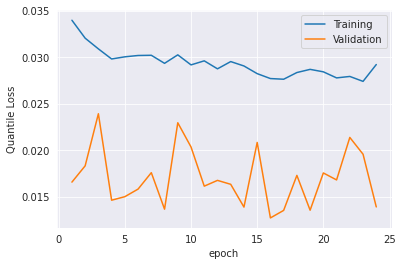

In [24]:
val_err_df[1:].plot(xlabel='epoch', ylabel='Quantile Loss')
plt.plot();

# Testing the model

Now that we've trained the model, let's verify how its performs on the test data. As shown above the test dataset is composed of the last part of total data, where there is the huge raise. Let's see how the model behaves in this kind of situation.

In [25]:
model.eval();

### 31th of March 2022

In [26]:
static_1, x_1, y_1 = testset[8727:8791]
in_dates, out_dates = testset.get_dates(slice(8727,8791, 1))

with torch.no_grad():
    out, _, _, attn_output, attn_weights, _, _ = model(x_1.to(device), static_1.to(device))

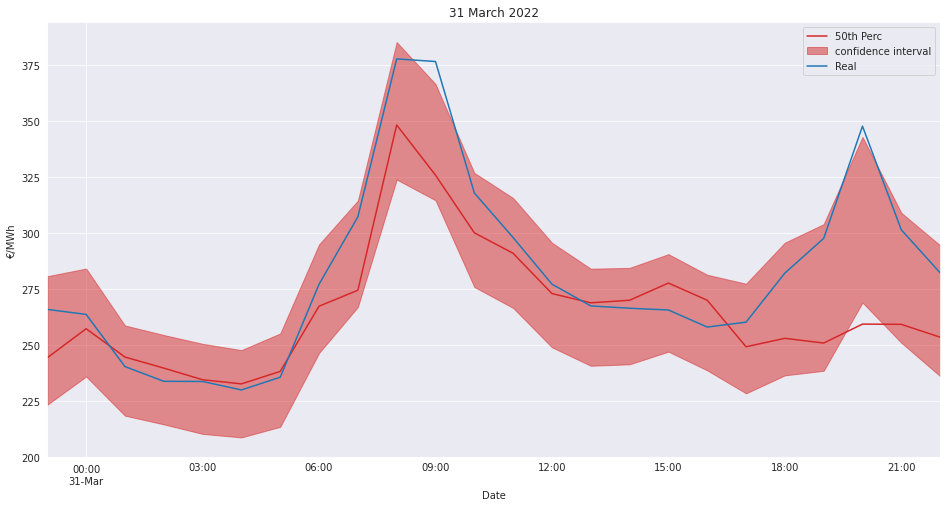

In [27]:
fig, ax = plt.subplots(figsize=(16, 8))
data_range = out_dates[-1]

pd.DataFrame({'50th Perc': output_sc.inverse_transform(out[-1][:, 1].detach().cpu().numpy().reshape(-1, 1)).squeeze()},
             index=data_range).plot(ax=ax, color='tab:red')
ax.fill_between(data_range,
                 output_sc.inverse_transform(out[-1][:, 0].detach().cpu().numpy().reshape(-1, 1)).squeeze(),
                 output_sc.inverse_transform(out[-1][:, 2].detach().cpu().numpy().reshape(-1, 1)).squeeze(),
                 alpha=.5, color='tab:red',
                 label='confidence interval')
pd.DataFrame({'Real': output_sc.inverse_transform(y_1[-1].detach().cpu().numpy().reshape(-1, 1)).squeeze()},
             index=data_range).plot(ax=ax)

ax.legend()
ax.set_title('31 March 2022')
ax.set_ylabel('€/MWh')
ax.set_xlabel('Date')
plt.show()

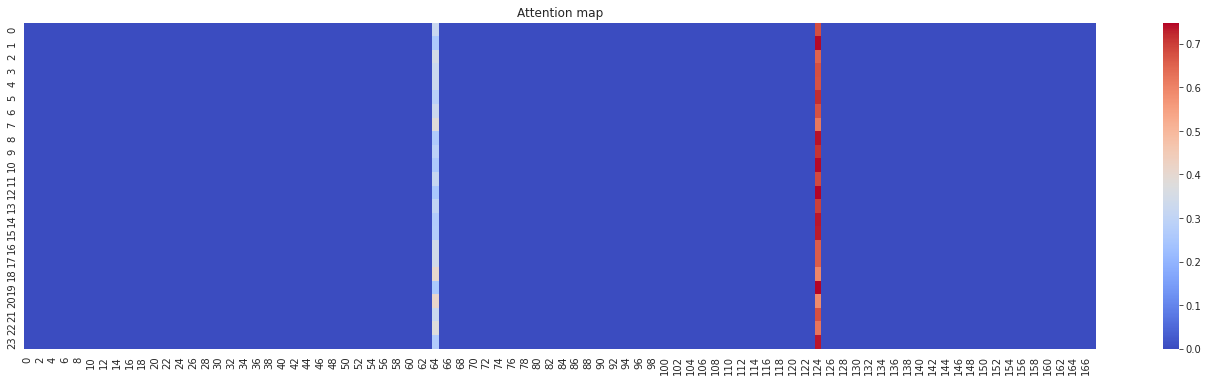

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(24, 6))

sns.heatmap(attn_weights.detach().cpu().numpy()[-1,:,:], cmap='coolwarm', ax=ax)

plt.title('Attention map')
plt.show()

### 01 March 2022

In [29]:
static_1, x_1, y_1 = testset[8007:8071]
in_dates, out_dates = testset.get_dates(slice(8007,8071, 1))

with torch.no_grad():
    out, _, _, attn_output, attn_weights, _, _ = model(x_1.to(device), static_1.to(device))

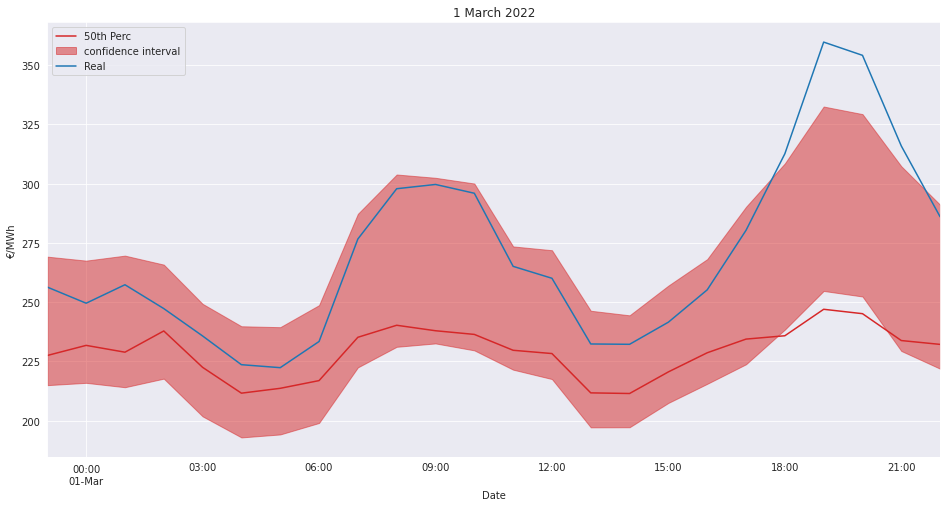

In [30]:
fig, ax = plt.subplots(figsize=(16, 8))
data_range = out_dates[-1]

pd.DataFrame({'50th Perc': output_sc.inverse_transform(out[-1][:, 1].detach().cpu().numpy().reshape(-1, 1)).squeeze()},
             index=data_range).plot(ax=ax, color='tab:red')
ax.fill_between(data_range,
                 output_sc.inverse_transform(out[-1][:, 0].detach().cpu().numpy().reshape(-1, 1)).squeeze(),
                 output_sc.inverse_transform(out[-1][:, 2].detach().cpu().numpy().reshape(-1, 1)).squeeze(),
                 alpha=.5, color='tab:red',
                 label='confidence interval')
pd.DataFrame({'Real': output_sc.inverse_transform(y_1[-1].detach().cpu().numpy().reshape(-1, 1)).squeeze()},
             index=data_range).plot(ax=ax)

ax.legend()
ax.set_title('1 March 2022')
ax.set_ylabel('€/MWh')
ax.set_xlabel('Date')
plt.show()

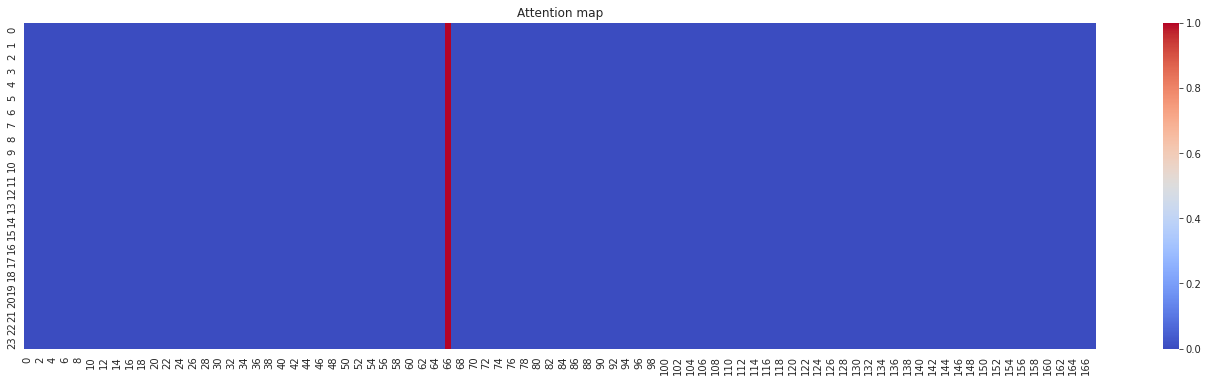

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(24, 6))

sns.heatmap(attn_weights.detach().cpu().numpy()[-1,:,:], cmap='coolwarm', ax=ax)

plt.title('Attention map')
plt.show()

### 8 March 2022

In [32]:
static_1, x_1, y_1 = testset[8175:8239]
in_dates, out_dates = testset.get_dates(slice(8175, 8239, 1))

with torch.no_grad():
    out, _, _, attn_output, attn_weights, _, _ = model(x_1.to(device), static_1.to(device))

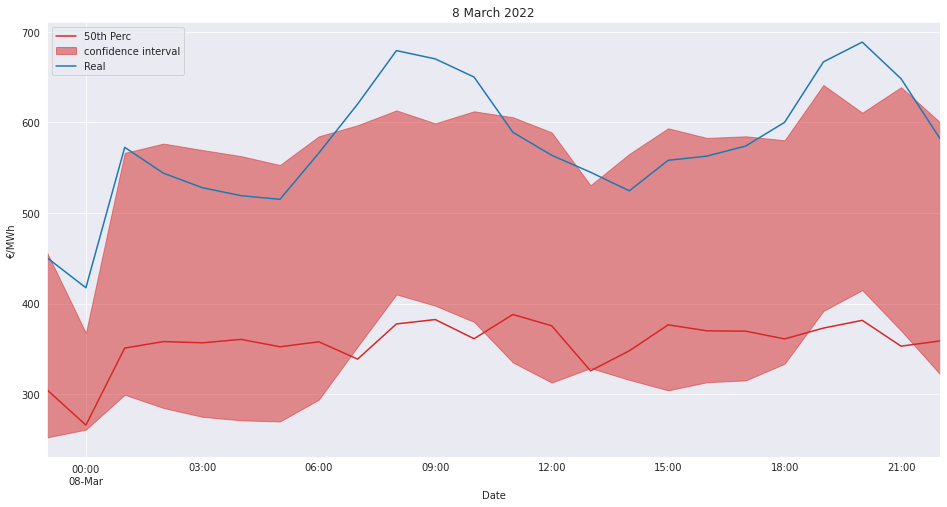

In [33]:
fig, ax = plt.subplots(figsize=(16, 8))
data_range = out_dates[-1]

pd.DataFrame({'50th Perc': output_sc.inverse_transform(out[-1][:, 1].detach().cpu().numpy().reshape(-1, 1)).squeeze()},
             index=data_range).plot(ax=ax, color='tab:red')
ax.fill_between(data_range,
                 output_sc.inverse_transform(out[-1][:, 0].detach().cpu().numpy().reshape(-1, 1)).squeeze(),
                 output_sc.inverse_transform(out[-1][:, 2].detach().cpu().numpy().reshape(-1, 1)).squeeze(),
                 alpha=.5, color='tab:red',
                 label='confidence interval')
pd.DataFrame({'Real': output_sc.inverse_transform(y_1[-1].detach().cpu().numpy().reshape(-1, 1)).squeeze()},
             index=data_range).plot(ax=ax)

ax.legend()
ax.set_title('8 March 2022')
ax.set_ylabel('€/MWh')
ax.set_xlabel('Date')
plt.show()

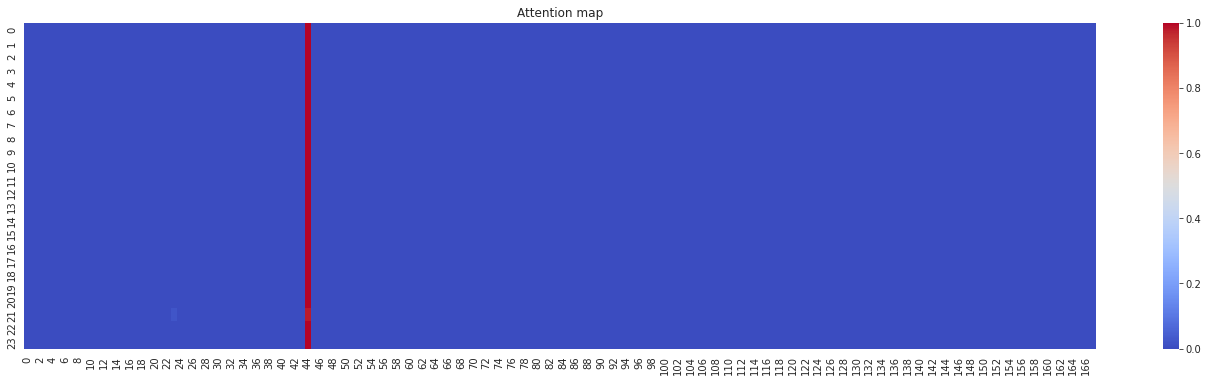

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(24, 6))

sns.heatmap(attn_weights.detach().cpu().numpy()[-1,:,:], cmap='coolwarm', ax=ax)

plt.title('Attention map')
plt.show()

### 13 March 2022

In [35]:
static_1, x_1, y_1 = testset[8295:8359]
in_dates, out_dates = testset.get_dates(slice(8295, 8359, 1))

with torch.no_grad():
    out, _, _, attn_output, attn_weights, _, _ = model(x_1.to(device), static_1.to(device))

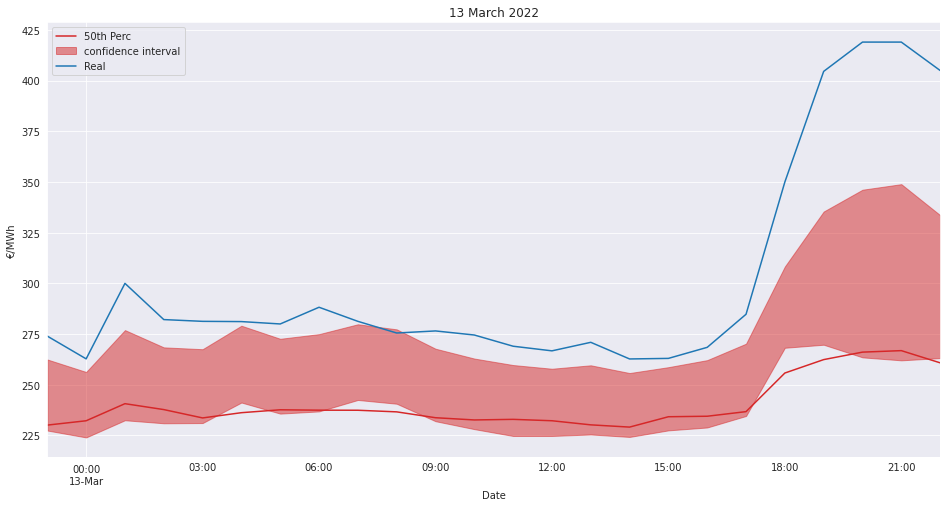

In [36]:
fig, ax = plt.subplots(figsize=(16, 8))
data_range = out_dates[-1]

pd.DataFrame({'50th Perc': output_sc.inverse_transform(out[-1][:, 1].detach().cpu().numpy().reshape(-1, 1)).squeeze()},
             index=data_range).plot(ax=ax, color='tab:red')
ax.fill_between(data_range,
                 output_sc.inverse_transform(out[-1][:, 0].detach().cpu().numpy().reshape(-1, 1)).squeeze(),
                 output_sc.inverse_transform(out[-1][:, 2].detach().cpu().numpy().reshape(-1, 1)).squeeze(),
                 alpha=.5, color='tab:red',
                 label='confidence interval')
pd.DataFrame({'Real': output_sc.inverse_transform(y_1[-1].detach().cpu().numpy().reshape(-1, 1)).squeeze()},
             index=data_range).plot(ax=ax)

ax.legend()
ax.set_title('13 March 2022')
ax.set_ylabel('€/MWh')
ax.set_xlabel('Date')
plt.show()

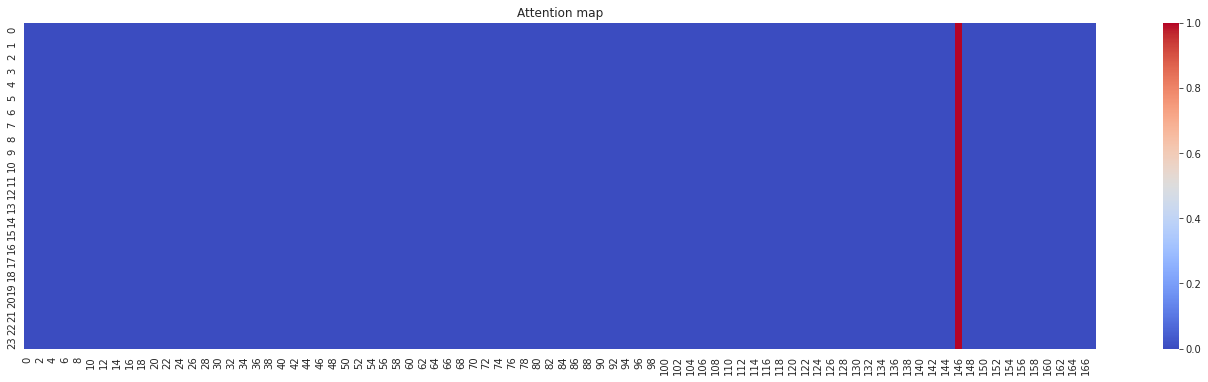

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(24, 6))

sns.heatmap(attn_weights.detach().cpu().numpy()[-1,:,:], cmap='coolwarm', ax=ax)

plt.title('Attention map')
plt.show()